In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer,wordnet
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
import keras
from keras import layers
from sklearn import metrics
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
# Run in case warnings should be ignored
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth',300)


In [2]:
# get data from txt-file
'''Wiki_article_ID
Freebase_ID
Book_title
Author
Publication_date
Book_genres (Freebase ID:name tuples)
Plot_summary'''
df01 = pd.read_csv('booksummaries.txt', sep="\t", header=None)
df01.columns = ['Wiki_article_ID', 'Freebase_ID', 'Book_title', 'Author','Publication_date','Book_genres','Plot_summary']


In [3]:
df01.head(3)

,Wiki_article_ID,Freebase_ID,Book_title,Author,Publication_date,Book_genres,Plot_summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"": ""Satire"", ""/m/0dwly"": ""Children's literature"", ""/m/014dfn"": ""Speculative fiction"", ""/m/02xlf"": ""Fiction""}","Old Major, the old boar on the Manor Farm, calls the animals on the farm for a meeting, where he compares the humans to parasites and teaches the animals a revolutionary song, 'Beasts of England'. When Major dies, two young pigs, Snowball and Napoleon, assume command and turn his dream into a p..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""Novella"", ""/m/014dfn"": ""Speculative fiction"", ""/m/0c082"": ""Utopian and dystopian fiction"", ""/m/06nbt"": ""Satire"", ""/m/02xlf"": ""Fiction""}","Alex, a teenager living in near-future England, leads his gang on nightly orgies of opportunistic, random ""ultra-violence."" Alex's friends (""droogs"" in the novel's Anglo-Russian slang, Nadsat) are: Dim, a slow-witted bruiser who is the gang's muscle; Georgie, an ambitious second-in-command; and..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fiction"", ""/m/0pym5"": ""Absurdist fiction"", ""/m/05hgj"": ""Novel""}","The text of The Plague is divided into five parts. In the town of Oran, thousands of rats, initially unnoticed by the populace, begin to die in the streets. A hysteria develops soon afterward, causing the local newspapers to report the incident. Authorities responding to public pressure order t..."


In [4]:
df01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16559 entries, 0 to 16558
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Wiki_article_ID   16559 non-null  int64 
 1   Freebase_ID       16559 non-null  object
 2   Book_title        16559 non-null  object
 3   Author            14177 non-null  object
 4   Publication_date  10949 non-null  object
 5   Book_genres       12841 non-null  object
 6   Plot_summary      16559 non-null  object
dtypes: int64(1), object(6)
memory usage: 905.7+ KB


In [5]:
df01.isnull().sum()

Wiki_article_ID        0
Freebase_ID            0
Book_title             0
Author              2382
Publication_date    5610
Book_genres         3718
Plot_summary           0
dtype: int64

In [6]:
# delete all the rows where 'Plot_summary' and 'Book_genres' are NaN
df01 = df01.dropna(subset=['Book_genres','Plot_summary'])

In [7]:
df01.isnull().sum()

Wiki_article_ID        0
Freebase_ID            0
Book_title             0
Author               786
Publication_date    3170
Book_genres            0
Plot_summary           0
dtype: int64

In [8]:
# convert 'Book_genres' from json format to list format
df01['Book_genres'] = df01['Book_genres'].map(lambda Book_genres : list(json.loads(Book_genres).values()))

In [9]:
df01['Book_genres'].value_counts()

Book_genres
[Novel]                                                                        839
[Science Fiction, Speculative fiction]                                         567
[Science Fiction]                                                              526
[Fiction]                                                                      402
[Fiction, Novel]                                                               381
                                                                              ... 
[Science Fiction, Speculative fiction, Mystery, Fantasy, Fiction, Suspense]      1
[Speculative fiction, Fantasy, Fiction, Literary fiction]                        1
[Fiction, Graphic novel, Anti-nuclear]                                           1
[Thriller, Spy fiction, Adventure novel]                                         1
[Epistolary novel, Speculative fiction]                                          1
Name: count, Length: 2154, dtype: int64

In [10]:
df01.Book_genres.values

array([list(['Roman à clef', 'Satire', "Children's literature", 'Speculative fiction', 'Fiction']),
       list(['Science Fiction', 'Novella', 'Speculative fiction', 'Utopian and dystopian fiction', 'Satire', 'Fiction']),
       list(['Existentialism', 'Fiction', 'Absurdist fiction', 'Novel']),
       ..., list(['Thriller', 'Fiction']), list(['Autobiography']),
       list(['Epistolary novel', 'Speculative fiction'])], dtype=object)

In [11]:
df01.Book_genres

0                            [Roman à clef, Satire, Children's literature, Speculative fiction, Fiction]
1        [Science Fiction, Novella, Speculative fiction, Utopian and dystopian fiction, Satire, Fiction]
2                                                    [Existentialism, Fiction, Absurdist fiction, Novel]
4                         [Hard science fiction, Science Fiction, Speculative fiction, Fantasy, Fiction]
5                                                                              [War novel, Roman à clef]
                                                      ...                                               
16549                                                                                  [Science Fiction]
16551                                                                      [Thriller, Fiction, Suspense]
16555                                                                                [Thriller, Fiction]
16556                                                  

In [12]:
list_genre_titles_01 = []
list_genre_titles_02 = []

In [13]:
for i in df01.Book_genres.values:
    list_genre_titles_01.append(str(i[0]))
    list_genre_titles_02.append(str(i[-1]))

In [14]:
# most frequently occurring values in Book_genres with the first and last of the lists
df01['Genre_01'] = list_genre_titles_01
df01['Genre_02'] = list_genre_titles_02

In [15]:
df02 = df01[['Genre_01','Genre_02','Plot_summary']]
df02.head(3)

,Genre_01,Genre_02,Plot_summary
0,Roman à clef,Fiction,"Old Major, the old boar on the Manor Farm, calls the animals on the farm for a meeting, where he compares the humans to parasites and teaches the animals a revolutionary song, 'Beasts of England'. When Major dies, two young pigs, Snowball and Napoleon, assume command and turn his dream into a p..."
1,Science Fiction,Fiction,"Alex, a teenager living in near-future England, leads his gang on nightly orgies of opportunistic, random ""ultra-violence."" Alex's friends (""droogs"" in the novel's Anglo-Russian slang, Nadsat) are: Dim, a slow-witted bruiser who is the gang's muscle; Georgie, an ambitious second-in-command; and..."
2,Existentialism,Novel,"The text of The Plague is divided into five parts. In the town of Oran, thousands of rats, initially unnoticed by the populace, begin to die in the streets. A hysteria develops soon afterward, causing the local newspapers to report the incident. Authorities responding to public pressure order t..."


In [16]:
df02.Genre_01.value_counts().head(10)

Genre_01
Science Fiction           2551
Speculative fiction       1438
Children's literature     1152
Fiction                    943
Novel                      925
Mystery                    734
Crime Fiction              672
Fantasy                    624
Thriller                   568
Young adult literature     321
Name: count, dtype: int64

In [17]:
# Genre_02 has a better distribution to work with
df02.Genre_02.value_counts().head(10)

Genre_02
Fiction                   2593
Novel                     2146
Fantasy                    943
Speculative fiction        899
Children's literature      713
Suspense                   686
Historical novel           637
Science Fiction            575
Young adult literature     418
Adventure novel            240
Name: count, dtype: int64

In [18]:
df02.Genre_02.value_counts().keys()[:10]

Index(['Fiction', 'Novel', 'Fantasy', 'Speculative fiction',
       'Children's literature', 'Suspense', 'Historical novel',
       'Science Fiction', 'Young adult literature', 'Adventure novel'],
      dtype='object', name='Genre_02')

In [19]:
list_Genre_new = []
for i in df02.Genre_02.value_counts().keys()[:10]:
    list_Genre_new.append(i)
type(list_Genre_new)

list

In [20]:
list_Genre_new

['Fiction',
 'Novel',
 'Fantasy',
 'Speculative fiction',
 "Children's literature",
 'Suspense',
 'Historical novel',
 'Science Fiction',
 'Young adult literature',
 'Adventure novel']

In [21]:
# i only use the samples with the values of my category list --> the first 2
df03 = df02[(df02['Genre_02'] == list_Genre_new[0]) | (df02['Genre_02'] == list_Genre_new[1])]

In [22]:
# the size of my data set to work with
df03.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4739 entries, 0 to 16555
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Genre_01      4739 non-null   object
 1   Genre_02      4739 non-null   object
 2   Plot_summary  4739 non-null   object
dtypes: object(3)
memory usage: 148.1+ KB


In [23]:
len(df03[df03.Genre_02 == 'Novel'])

2146

In [24]:
len(df03[df03.Genre_02 == 'Fiction'].iloc[:2146,:])

2146

In [25]:
# create the same number of categories
df03.drop(index=df03[df03.Genre_02 == 'Fiction'].iloc[2146:,:].index,inplace=True)

In [26]:
df03.Genre_02.value_counts()

Genre_02
Fiction    2146
Novel      2146
Name: count, dtype: int64

In [27]:
df03 = df03[['Genre_02','Plot_summary']]

In [28]:
df03.reset_index(drop=True,inplace=True)

In [29]:
df03.head(3)

,Genre_02,Plot_summary
0,Fiction,"Old Major, the old boar on the Manor Farm, calls the animals on the farm for a meeting, where he compares the humans to parasites and teaches the animals a revolutionary song, 'Beasts of England'. When Major dies, two young pigs, Snowball and Napoleon, assume command and turn his dream into a p..."
1,Fiction,"Alex, a teenager living in near-future England, leads his gang on nightly orgies of opportunistic, random ""ultra-violence."" Alex's friends (""droogs"" in the novel's Anglo-Russian slang, Nadsat) are: Dim, a slow-witted bruiser who is the gang's muscle; Georgie, an ambitious second-in-command; and..."
2,Novel,"The text of The Plague is divided into five parts. In the town of Oran, thousands of rats, initially unnoticed by the populace, begin to die in the streets. A hysteria develops soon afterward, causing the local newspapers to report the incident. Authorities responding to public pressure order t..."


In [30]:
# remove duplicates in Plot_summary
df04 = df03.drop_duplicates(subset='Plot_summary',keep=False)
df04.Plot_summary.value_counts().max()

1

In [31]:
df04.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4283 entries, 0 to 4291
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Genre_02      4283 non-null   object
 1   Plot_summary  4283 non-null   object
dtypes: object(2)
memory usage: 100.4+ KB


In [32]:
# collection of functions to clean the text in 1 function:
def lower(text):
    return str(text).lower()

# Remove HTML
def remove_HTML(text):
    return re.sub(r'<.*?>', '', text) 

def remove_punctuation(text):
    return text.translate(str.maketrans('','',string.punctuation))

# Removing all words with digits and standalone digits
def remove_digits(text):
    return re.sub(r'\d+', '', text)

stopwords = stopwords.words("english")
def remove_stopwords(text):
    global stopwords
    new = []
    # --> all text tokenized: print(word_tokenize(str(text)))
    for el in word_tokenize(str(text)):
        if not el in stopwords:
            new.append(el)
    return ' '.join(new)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Removing all non-printable symbols like "ड", "ட"
def remove_non_printable(text):
    text = text.encode("ascii", "ignore")
    return text.decode()
        
# One function to clean it all
def clean_text(text):
    text = lower(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = remove_digits(text)
    text = remove_emoji(text)
    text = remove_HTML(text)
    text = remove_non_printable(text)
    return text

In [33]:
df04['Clean_Plot_summary'] = df04['Plot_summary'].apply(clean_text)

In [34]:
df04.head(3)

,Genre_02,Plot_summary,Clean_Plot_summary
0,Fiction,"Old Major, the old boar on the Manor Farm, calls the animals on the farm for a meeting, where he compares the humans to parasites and teaches the animals a revolutionary song, 'Beasts of England'. When Major dies, two young pigs, Snowball and Napoleon, assume command and turn his dream into a p...",old major old boar manor farm calls animals farm meeting compares humans parasites teaches animals revolutionary song beasts england major dies two young pigs snowball napoleon assume command turn dream philosophy animals revolt drive drunken irresponsible mr jones farm renaming animal farm adop...
1,Fiction,"Alex, a teenager living in near-future England, leads his gang on nightly orgies of opportunistic, random ""ultra-violence."" Alex's friends (""droogs"" in the novel's Anglo-Russian slang, Nadsat) are: Dim, a slow-witted bruiser who is the gang's muscle; Georgie, an ambitious second-in-command; and...",alex teenager living nearfuture england leads gang nightly orgies opportunistic random ultraviolence alexs friends droogs novels anglorussian slang nadsat dim slowwitted bruiser gangs muscle georgie ambitious secondincommand pete mostly plays along droogs indulge taste ultraviolence characterize...
2,Novel,"The text of The Plague is divided into five parts. In the town of Oran, thousands of rats, initially unnoticed by the populace, begin to die in the streets. A hysteria develops soon afterward, causing the local newspapers to report the incident. Authorities responding to public pressure order t...",text plague divided five parts town oran thousands rats initially unnoticed populace begin die streets hysteria develops soon afterward causing local newspapers report incident authorities responding public pressure order collection cremation rats unaware collection catalyst spread bubonic plagu...


In [35]:
# shuffle the data before working with it
df05 = df04[['Genre_02','Clean_Plot_summary']].sample(frac=1.0,random_state=33)
df05.head(3)

,Genre_02,Clean_Plot_summary
53,Fiction,teenager matt dodson applies join prestigious space patrol number physical mental ethical tests accepted cadet makes friends fellow recruits william tex jarman venusborn oscar jensen pierre armand ganymede first roommate girard burke arrogant son wealthy spaceship builder transported orbiting s...
369,Fiction,title character fifteenyearold boy lives small town us state texas friend jesus navarro commits suicide killing sixteen bullying schoolmates suspicion falls vernon becomes something scapegoat small hometown martirio fearing death penalty goes run mexico
2891,Novel,early jenkins joins regiment wales second lieutenant introduced commanding officer officious captain gwatkin alcoholic lieutenant bithel battalion moved northern ireland gwatkin disastrously muddles instructions exercise snap inspection general liddament en route training course aldershot nick ...


In [36]:
len(df05.Genre_02.value_counts())

2

In [37]:
# create new, regular indices
df05.reset_index(drop=True,inplace=True)

In [38]:
df05.head(3)

,Genre_02,Clean_Plot_summary
0,Fiction,teenager matt dodson applies join prestigious space patrol number physical mental ethical tests accepted cadet makes friends fellow recruits william tex jarman venusborn oscar jensen pierre armand ganymede first roommate girard burke arrogant son wealthy spaceship builder transported orbiting s...
1,Fiction,title character fifteenyearold boy lives small town us state texas friend jesus navarro commits suicide killing sixteen bullying schoolmates suspicion falls vernon becomes something scapegoat small hometown martirio fearing death penalty goes run mexico
2,Novel,early jenkins joins regiment wales second lieutenant introduced commanding officer officious captain gwatkin alcoholic lieutenant bithel battalion moved northern ireland gwatkin disastrously muddles instructions exercise snap inspection general liddament en route training course aldershot nick ...


In [39]:
df05.shape

(4283, 2)

In [40]:
# preprocessing --> unique summaries
data = df05['Clean_Plot_summary'].map(word_tokenize).values
# create a set from nested comprehension --> unique words
total_vocabulary = set(word for summary in data for word in summary) 

In [41]:
print('There are {} unique words in the dataset.'.format(len(total_vocabulary)))
print('There are {} unique tweets in the dataset.'.format(len(data)))

There are 71476 unique words in the dataset.
There are 4283 unique tweets in the dataset.


In [42]:
# set the genre as our target
target = df05['Genre_02']

In [43]:
# use one hot encoding at the target
y = pd.get_dummies(target).values

In [44]:
y

array([[ True, False],
       [ True, False],
       [False,  True],
       ...,
       [False,  True],
       [ True, False],
       [ True, False]])

In [45]:
# use keras to create a tokenizer object
#       limit to the num_words most important ones
tokenizer = text.Tokenizer(num_words=20000)  
tokenizer.fit_on_texts(list(df05['Clean_Plot_summary']))
tokenized_texts = tokenizer.texts_to_sequences(df05['Clean_Plot_summary'])
X = sequence.pad_sequences(tokenized_texts, maxlen=100)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=33)

In [47]:
# building the model
# create my NN model
model = Sequential()

embedding_size = 128
model.add(Embedding(len(total_vocabulary), embedding_size))
model.add(LSTM(25, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
# use 2 because we have 2 categories
model.add(Dense(2, activation='softmax'))  

In [48]:
# training the model
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['Accuracy'])

# check the shape
model.summary() 


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         9148928   
                                                                 
 lstm (LSTM)                 (None, None, 25)          15400     
                                                                 
 global_max_pooling1d (Glob  (None, 25)                0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 25)                0         
                                                                 
 dense (Dense)               (None, 50)                1300      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                       

In [49]:
model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.1)

Epoch 1/15


97/97 [==============================] - 17s 143ms/step - loss: 0.6938 - Accuracy: 0.5183 - val_loss: 0.6921 - val_Accuracy: 0.4985
Epoch 2/15
97/97 [==============================] - 13s 134ms/step - loss: 0.6799 - Accuracy: 0.5592 - val_loss: 0.6536 - val_Accuracy: 0.6385
Epoch 3/15
97/97 [==============================] - 13s 134ms/step - loss: 0.5573 - Accuracy: 0.7395 - val_loss: 0.6615 - val_Accuracy: 0.6501
Epoch 4/15
97/97 [==============================] - 13s 135ms/step - loss: 0.3077 - Accuracy: 0.8904 - val_loss: 1.1740 - val_Accuracy: 0.6093
Epoch 5/15
97/97 [==============================] - 13s 134ms/step - loss: 0.1541 - Accuracy: 0.9543 - val_loss: 1.2446 - val_Accuracy: 0.6443
Epoch 6/15
97/97 [==============================] - 13s 135ms/step - loss: 0.0589 - Accuracy: 0.9851 - val_loss: 1.5850 - val_Accuracy: 0.6327
Epoch 7/15
97/97 [==============================] - 13s 135ms/step - loss: 0.0319 - Accuracy: 0.9929 - val_loss: 2.7620 - val_Accuracy: 0.64

In [50]:
 # get my predictions
y_pred = model.predict(X_test)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
acc = accuracy_score(y_test,y_pred) 
print('Overall accuracy of RNN: {:.3f}'.format(acc))

27/27 [==============================] - 1s 15ms/step
Overall accuracy of RNN: 0.639


In [51]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[259, 172],
       [137, 289]], dtype=int64)

<Axes: >

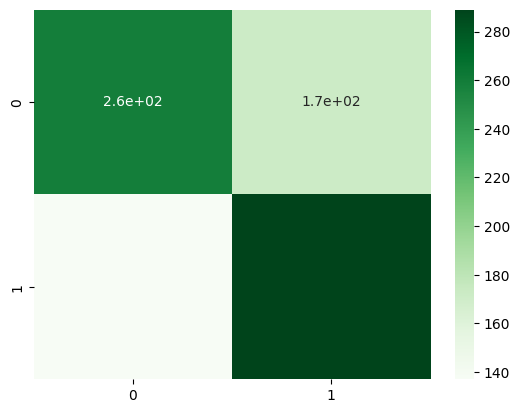

In [52]:
# confusion-matrix visualization
sns.heatmap(cm, annot=True, cmap='Greens')

In [53]:
# get test metrics
preds = model(X_test)
preds = preds.numpy()
preds = preds>0.5
preds=np.argmax(preds, axis=1)
print("Accuracy is", metrics.accuracy_score(y_test, preds))
print("F1 score is", metrics.f1_score(y_test, preds,average='weighted'))
print("Precision is", metrics.precision_score(y_test, preds,average='weighted'))
print("Recall is", metrics.recall_score(y_test, preds,average='weighted'))

Accuracy is 0.6394399066511085
F1 score is 0.6389238019355186
Precision is 0.6405484042837015
Recall is 0.6394399066511085
